In [6]:
# (Uncomment if you need to install)
#pip install pygame gym torch torchvision numpy matplotlib

import os
import random
import numpy as np
import pygame
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import count


In [7]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [16]:
class SnakeEnv:
    def __init__(self, width=10, height=10, block_size=20):
        pygame.init()
        self.width, self.height, self.block = width, height, block_size
        # use self.block, not block
        self.display = pygame.Surface((self.width * self.block,
                                       self.height * self.block))
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self):
        self.direction = (1, 0)
        self.snake = [(self.width//2, self.height//2)]
        self._place_food()
        self.done, self.score = False, 0
        return self._get_obs()

    def _place_food(self):
        import random
        while True:
            self.food = (random.randrange(self.width),
                         random.randrange(self.height))
            if self.food not in self.snake:
                break

    def _get_obs(self):
        grid = np.zeros((self.width, self.height), dtype=np.int8)
        for x,y in self.snake: grid[x,y] = 1
        fx,fy = self.food; grid[fx,fy] = 2
        return grid.flatten().astype(np.float32)

    def step(self, action):
        dirs = [(-1,0),(0,1),(1,0),(0,-1)]
        new_dir = dirs[action]
        if (new_dir[0]==-self.direction[0] and
            new_dir[1]==-self.direction[1]):
            new_dir = self.direction
        self.direction = new_dir

        head = (self.snake[0][0]+new_dir[0],
                self.snake[0][1]+new_dir[1])
        if (not 0<=head[0]<self.width or
            not 0<=head[1]<self.height or
            head in self.snake):
            self.done = True
            return self._get_obs(), -10, True, {}

        self.snake.insert(0, head)
        if head == self.food:
            reward, self.score = 10, self.score+1
            self._place_food()
        else:
            reward = 0
            self.snake.pop()

        return self._get_obs(), reward, False, {}

    # Inside your SnakeEnv class, overwrite render() with:

    def render(self):
        """
        Return a (H_px, W_px, 3) uint8 image of the game:
         - snake in green, food in red, background black.
        """
        H_px = self.height * self.block
        W_px = self.width  * self.block
        frame = np.zeros((H_px, W_px, 3), dtype=np.uint8)

        # Draw snake
        for x, y in self.snake:
            y0, y1 = y*self.block, (y+1)*self.block
            x0, x1 = x*self.block, (x+1)*self.block
            frame[y0:y1, x0:x1] = np.array([0,255,0], dtype=np.uint8)

        # Draw food
        fx, fy = self.food
        y0, y1 = fy*self.block, (fy+1)*self.block
        x0, x1 = fx*self.block, (fx+1)*self.block
        frame[y0:y1, x0:x1] = np.array([255,0,0], dtype=np.uint8)

        return frame



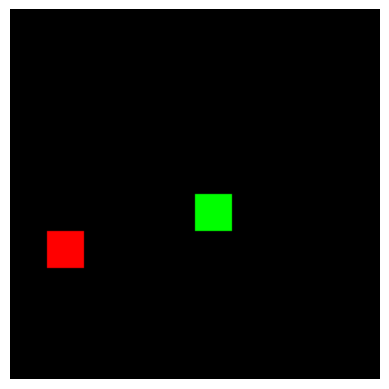

In [23]:
# Test cell – display the raw NumPy frame
env = SnakeEnv(width=10, height=10, block_size=20)
obs = env.reset()
frame = env.render()   # now an (H_px, W_px, 3) array

import matplotlib.pyplot as plt
plt.imshow(frame)
plt.axis('off')
plt.show()


In [24]:
from collections import deque, namedtuple
import random

# Define a transition tuple
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        """Save a transition."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Randomly sample a batch of transitions."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


# Instantiate and test
memory = ReplayMemory(capacity=1000)

# Push a dummy transition
dummy_state  = env.reset()
dummy_action = 0
dummy_reward = 1.0
dummy_next   = dummy_state
dummy_done   = False
memory.push(dummy_state, dummy_action, dummy_reward, dummy_next, dummy_done)

# Sample should return a list of length 1
batch = memory.sample(1)
print("Sampled batch:", batch)
print("Buffer length:", len(memory))


Sampled batch: [Transition(state=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), action=0, reward=1.0, next_state=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32), done

In [25]:
# Cell 7 – DQN Network Definition

import torch.nn as nn

state_dim  = env.width * env.height    # flattened grid size
action_dim = 4                         # up, right, down, left

class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate policy and target networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
# Initialize target to match policy
target_net.load_state_dict(policy_net.state_dict())


<All keys matched successfully>

In [26]:
# Cell 8 – Action Selection, Optimizer, and DQN Update

import torch.optim as optim
import torch.nn.functional as F

# ε‑greedy action selection
def select_action(state, eps):
    """
    state: 1D numpy array of length state_dim
    eps: float between 0 and 1
    returns: int action in [0, action_dim)
    """
    if random.random() < eps:
        return random.randrange(action_dim)
    # otherwise pick best Q-value action
    state_v = torch.from_numpy(state).unsqueeze(0).to(device)   # shape [1, state_dim]
    with torch.no_grad():
        q_vals = policy_net(state_v)                            # shape [1, action_dim]
    return int(q_vals.argmax(dim=1).item())

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)

# Single DQN update step
def optimize_dqn(batch_size, gamma):
    if len(memory) < batch_size:
        return

    # Sample a batch
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    # Convert to tensors
    states      = torch.tensor(batch.state,      dtype=torch.float32, device=device)
    actions     = torch.tensor(batch.action,     dtype=torch.int64,   device=device).unsqueeze(1)
    rewards     = torch.tensor(batch.reward,     dtype=torch.float32, device=device).unsqueeze(1)
    next_states = torch.tensor(batch.next_state, dtype=torch.float32, device=device)
    dones       = torch.tensor(batch.done,       dtype=torch.float32, device=device).unsqueeze(1)

    # Current Q values
    q_values = policy_net(states).gather(1, actions)   # shape [batch_size, 1]

    # Next state values from target network
    next_q = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    expected_q = rewards + gamma * next_q * (1.0 - dones)

    # Compute loss and backprop
    loss = F.mse_loss(q_values, expected_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [27]:
# Cell 9 – Hyperparameters & Checkpoints

# RL hyperparameters
config = {
    "gamma":           0.99,    # discount factor
    "batch_size":      64,      # replay batch size
    "eps_start":       1.0,     # initial ε for ε‑greedy
    "eps_end":         0.01,    # final ε
    "eps_decay":       1000,    # decay rate for ε
    "target_update":   10,      # episodes between target network sync
    "num_episodes":    500      # total training episodes
}

# Checkpoint directory and file
ckpt_dir  = "checkpoints"
ckpt_path = os.path.join(ckpt_dir, "dqn_snake.pth")
os.makedirs(ckpt_dir, exist_ok=True)

print("Config:", config)
print("Checkpoint will be saved to:", ckpt_path)


Config: {'gamma': 0.99, 'batch_size': 64, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 1000, 'target_update': 10, 'num_episodes': 500}
Checkpoint will be saved to: checkpoints/dqn_snake.pth


In [28]:
# Cell 10 – Checkpoint Save & Load

def save_checkpoint():
    """Save policy network and optimizer states."""
    torch.save({
        "policy_state_dict": policy_net.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, ckpt_path)
    print(f"Checkpoint saved to {ckpt_path}")

def load_checkpoint():
    """Load policy network and optimizer states if available."""
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=device)
        policy_net.load_state_dict(checkpoint["policy_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        target_net.load_state_dict(policy_net.state_dict())
        print(f"Loaded checkpoint from {ckpt_path}")
    else:
        print("No checkpoint found, starting from scratch.")

# Test load & save
load_checkpoint()        # Expect “No checkpoint found...” on first run
save_checkpoint()        # Should print confirmation
load_checkpoint()        # Now should load successfully


No checkpoint found, starting from scratch.
Checkpoint saved to checkpoints/dqn_snake.pth
Loaded checkpoint from checkpoints/dqn_snake.pth


/var/folders/5t/35w5sh2n3r196t69kjv4ldm00000gn/T/ipykernel_10131/1756321651.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locat

In [29]:
# Cell 11 – Training Loop (test run for a few episodes)

episode_rewards = []
steps_done = 0

def get_epsilon(step):
    """Exponential decay from eps_start to eps_end."""
    return config["eps_end"] + (config["eps_start"] - config["eps_end"]) * \
           np.exp(-1. * step / config["eps_decay"])

# Run a brief training to check integration
for ep in range(1, 21):  # just 20 episodes for a quick test
    state = env.reset()
    total_reward = 0
    
    while True:
        eps = get_epsilon(steps_done)
        action = select_action(state, eps)
        next_state, reward, done, _ = env.step(action)
        
        # Store transition and learn
        memory.push(state, action, reward, next_state, done)
        optimize_dqn(config["batch_size"], config["gamma"])
        
        state = next_state
        total_reward += reward
        steps_done += 1
        
        if done:
            break

    episode_rewards.append(total_reward)
    
    # Periodically update target network
    if ep % config["target_update"] == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # Print progress
    print(f"Episode {ep:2d} | Reward: {total_reward}")

# Save final checkpoint
save_checkpoint()


Episode  1 | Reward: -10
Episode  2 | Reward: -10
Episode  3 | Reward: -10
Episode  4 | Reward: -10
Episode  5 | Reward: -10


/var/folders/5t/35w5sh2n3r196t69kjv4ldm00000gn/T/ipykernel_10131/364825624.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647038473/work/torch/csrc/utils/tensor_new.cpp:281.)
  states      = torch.tensor(batch.state,      dtype=torch.float32, device=device)


Episode  6 | Reward: -10
Episode  7 | Reward: -10
Episode  8 | Reward: -10
Episode  9 | Reward: -10
Episode 10 | Reward: -10
Episode 11 | Reward: -10
Episode 12 | Reward: -10
Episode 13 | Reward: -10
Episode 14 | Reward: -10
Episode 15 | Reward: -10
Episode 16 | Reward: -10
Episode 17 | Reward: -10
Episode 18 | Reward: -10
Episode 19 | Reward: -10
Episode 20 | Reward: -10
Checkpoint saved to checkpoints/dqn_snake.pth


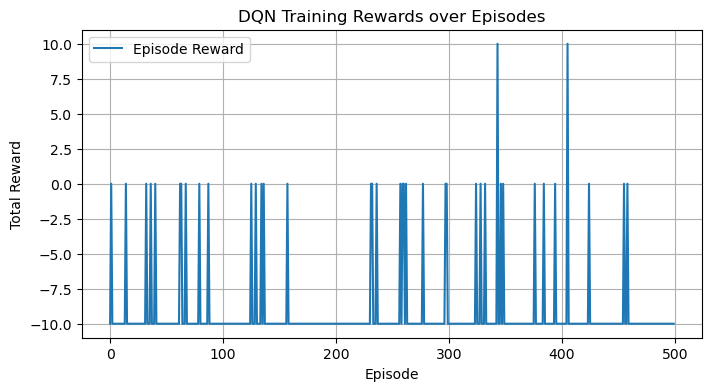

In [34]:
# Cell 12 – Training Rewards Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(episode_rewards, label="Episode Reward")
plt.title("DQN Training Rewards over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.show()


In [35]:
# Cell 13 – Policy Evaluation (no exploration)

def evaluate_policy(net, env, n_episodes=10):
    net.eval()
    scores = []
    with torch.no_grad():
        for _ in range(n_episodes):
            state = env.reset()
            total = 0
            done = False
            while not done:
                # always pick greedy action
                state_v = torch.from_numpy(state).unsqueeze(0).to(device)
                action = net(state_v).argmax(dim=1).item()
                state, reward, done, _ = env.step(action)
                total += reward
            scores.append(total)
    net.train()
    return scores

# Run evaluation
eval_scores = evaluate_policy(policy_net, env, n_episodes=20)
print(f"Evaluation over 20 episodes: mean={np.mean(eval_scores):.2f}, "
      f"std={np.std(eval_scores):.2f}")


KeyboardInterrupt: 

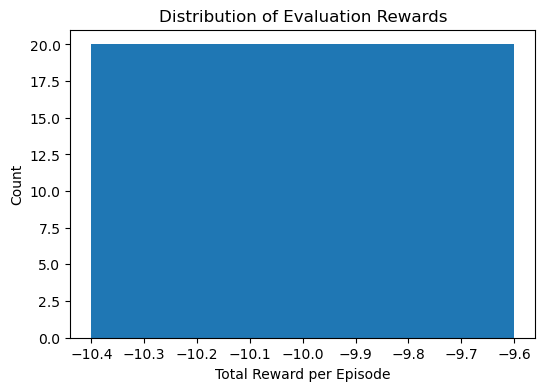

In [32]:
# Cell 14 – Evaluation Score Distribution

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(eval_scores, bins=range(min(eval_scores), max(eval_scores)+2), align='left', rwidth=0.8)
plt.title("Distribution of Evaluation Rewards")
plt.xlabel("Total Reward per Episode")
plt.ylabel("Count")
plt.show()


In [33]:
# Cell 15 – Full Training Run

# (Re‑initialize if you’d like to start fresh; otherwise you’ll resume from checkpoint)
# load_checkpoint()

episode_rewards = []
steps_done = 0

for ep in range(1, config["num_episodes"] + 1):
    state = env.reset()
    total_reward = 0
    
    while True:
        eps = get_epsilon(steps_done)
        action = select_action(state, eps)
        next_state, reward, done, _ = env.step(action)

        memory.push(state, action, reward, next_state, done)
        optimize_dqn(config["batch_size"], config["gamma"])

        state = next_state
        total_reward += reward
        steps_done += 1

        if done:
            break

    episode_rewards.append(total_reward)

    # Update target network periodically
    if ep % config["target_update"] == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Log progress every 50 episodes
    if ep % 50 == 0:
        print(f"Episode {ep:3d} | Reward: {total_reward}")

# Save final model
save_checkpoint()


Episode  50 | Reward: -10
Episode 100 | Reward: -10
Episode 150 | Reward: -10
Episode 200 | Reward: -10
Episode 250 | Reward: -10
Episode 300 | Reward: -10
Episode 350 | Reward: -10
Episode 400 | Reward: -10
Episode 450 | Reward: -10
Episode 500 | Reward: -10
Checkpoint saved to checkpoints/dqn_snake.pth
